In [1]:
import libScatter as libSc
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt

# Read in the data
it=0
with nc.Dataset('WRF_MCS_20180625_07:00_%2.2i.nc'%it) as f:
    kext=f.variables['kext'][:]
    salb=f.variables['salb'][:]
    asym=f.variables['asym'][:]
    T=f.variables['t'][:]
    xlon=f.variables['xlon'][:]
    xlat=f.variables['xlat'][:]
#tbout = libSc.radtran_pp(umu,btemp,lyrtemp,lyrhgt,kextu,salbu,asymu,kextd,salbd,asymd,fisot,emis,ebar,ilambert)
lats = np.linspace(-70,69.75,num=560) #lower left latitude of each grid box
lons = np.linspace(-180,179.75,num=1440)#lower left longitude of each grid box
lats2,lons2=np.meshgrid(lats,lons)
emis_mean_grid = np.load('/Users/mgrecu/gpm_emis/data/emis_mean_grid_bare.masked.npy')

In [26]:
nz,ny,nx,nmfreq = kext.shape
umu=np.cos(53/180*np.pi)
ifreq=0
ilambert=1
fisot=2.7
emis=0.99
ebar=0.99
lyrhgt=np.arange(nz+1)*0.25
tb2d=np.zeros((ny,nx))
emiss2d=np.zeros((ny,nx))
ifreqE=2
ifreq=1
for i in range(nx):
    for j in range(ny):
        i0=int((xlon[j,i]+180)/0.25)
        j0=int((xlat[j,i]+70)/0.25)
        f1=(xlon[j,i]+180)/0.25-i0
        f2=(xlat[j,i]+70)/0.25-j0
        emis=(1-f1)*(1-f2)*emis_mean_grid[5,j0,i0,ifreqE]+f1*(1-f2)*emis_mean_grid[5,j0,i0+1,ifreqE]+\
                (1-f1)*f2*emis_mean_grid[5,j0+1,i0,ifreqE]+f1*f2*emis_mean_grid[5,j0+1,i0+1,ifreqE]
        ebar=emis
        emiss2d[j,i]=emis
        #tbout_pp=libSc.radtran_pp(umu,T[0,j,i],T[:,j,i],lyrhgt,kext[:,j,i,ifreq],salb[:,j,i,ifreq],asym[:,j,i,ifreq],\
        #                       kext[:,j,i,ifreq],salb[:,j,i,ifreq],asym[:,j,i,ifreq],fisot,emis,ebar,ilambert)
        tbout=libSc.radtran(umu,T[0,j,i],T[:,j,i],lyrhgt,kext[:,j,i,ifreq],salb[:,j,i,ifreq],asym[:,j,i,ifreq],\
                            fisot,emis,ebar)
        tb2d[j,i]=tbout
        #break


In [4]:
print(tbout,tbout_pp)

294.5748596191406 294.58709716796875


In [5]:
#Set various indices for accessing data and plotting


(12, 560, 1440, 11)
0.25 0.25


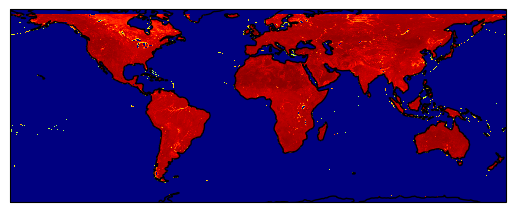

In [12]:
print(emis_mean_grid.shape)
import cartopy.crs as ccrs
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
plt.pcolormesh(lons2,lats2,emis_mean_grid[5,:,:,0].T,cmap='jet',vmin=0,vmax=1)
print(lats[1]-lats[0],lons[1]-lons[0])

In [11]:
print(emis_mean_grid[5,:,:,0].min())

-999.0


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


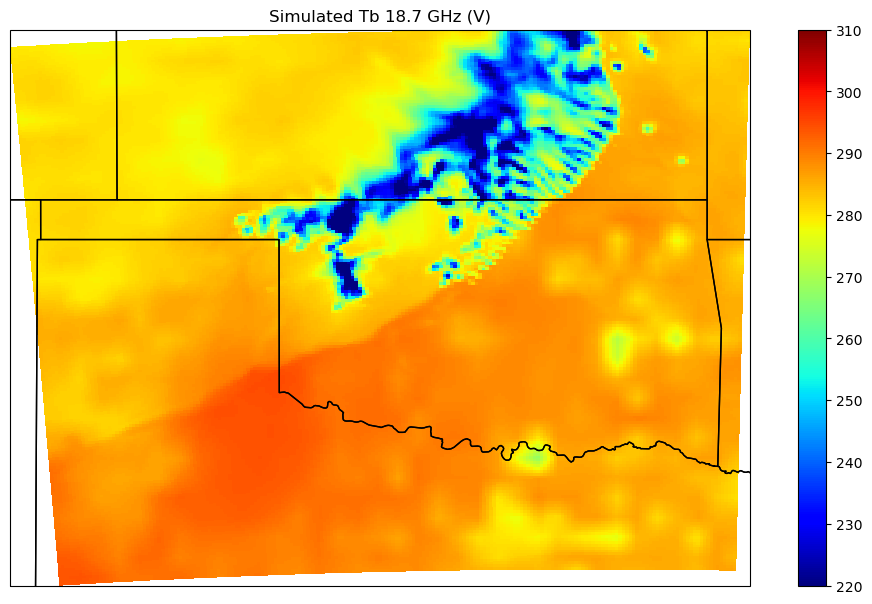

In [27]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

plt.figure(figsize=(10,6))
ax=plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xlon,xlat,tb2d,vmin=220,vmax=310,cmap='jet')
plt.colorbar()
plt.tight_layout()
chnames = ['10.65V','10.65H','18.7V','18.7H','23.8V','36.64V','36.64H','89V','89H','166V','166H']
plt.title('Simulated Tb 18.7 GHz (V)')
ax.add_feature(cfeature.STATES)
plt.savefig('tb_sim_18.7V.png',dpi=300)


#plot states


/Users/mgrecu/miniconda3/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1785: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  result = super().pcolormesh(*args, **kwargs)


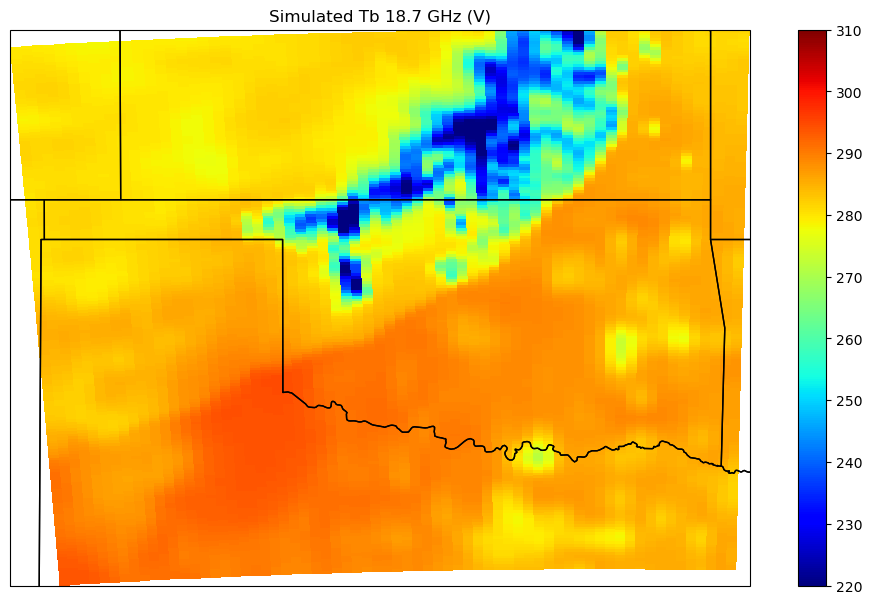

In [44]:
from scipy import ndimage
beam_w=np.zeros((7,7),float)
fov_dt_microw=[ 36./2., 18./2., 9.7/2., 4.2, 1.1 ]
fov_ct_microw=[ 60./2., 30./2., 16./2., 6.8, 2.2 ]

dx=4.0
for i in range(7):
    for j in range(7):
        ddx=(i-3)*dx
        ddy=(j-3)*dx
        FWHMx=fov_dt_microw[1]
        FWHMy=fov_ct_microw[1]
        y2=(((ddx/FWHMx)**2+(ddy/FWHMy)**2)* \
                                        4*np.log(2.))
        beam_w[j,i]=np.exp(-y2)
beam_w=beam_w/beam_w.sum()
tb2dconv=ndimage.convolve(tb2d, beam_w, mode='nearest')
plt.figure(figsize=(10,6))
ax=plt.axes(projection=ccrs.PlateCarree())
plt.pcolormesh(xlon[:,::3],xlat[:,::3],tb2dconv[:,::3],vmin=220,vmax=310,cmap='jet')
plt.colorbar()
plt.tight_layout()
chnames = ['10.65V','10.65H','18.7V','18.7H','23.8V','36.64V','36.64H','89V','89H','166V','166H']
plt.title('Simulated Tb 18.7 GHz (V)')
ax.add_feature(cfeature.STATES)
plt.savefig('tb_simConv_18.7V.png',dpi=300)


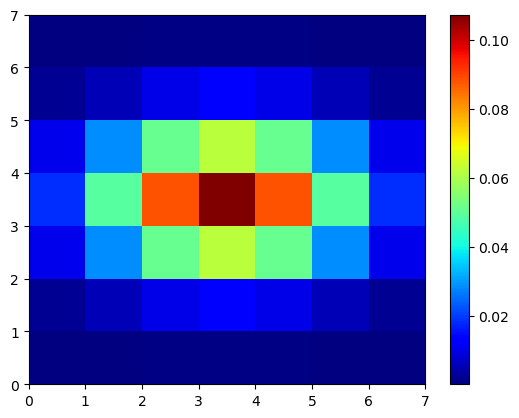

In [42]:
plt.pcolormesh(beam_w,cmap='jet')
plt.colorbar()


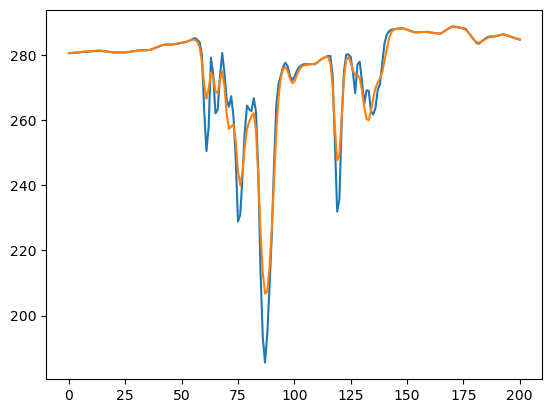

In [45]:

plt.plot(tb2d[120,:])
plt.plot(tb2dconv[120,:])